# Produce example arterial pressure waveform

This is later used by `sidewinder.synthetic.synthetic_arterial_pressure_data()` to generate synthetic arterial pressure data.

Data are used under the terms of the [VitalDB Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb). If you do not agree with this agreement, please close this file.

In [1]:
import os, sys
sys.path.append(os.pardir)  # Needed for sidewinder import before we install it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf

from sidewinder.utils import get_root_directory

Load short segment of arterial pressure waveform:

In [2]:
waveforms = pd.read_csv(
    os.path.join(
        get_root_directory(),
        'local_data',
        'abp_waveform_extract.csv'
    ),
    index_col=0
)

art = waveforms['SNUADC/ART'].values[100205:101980]

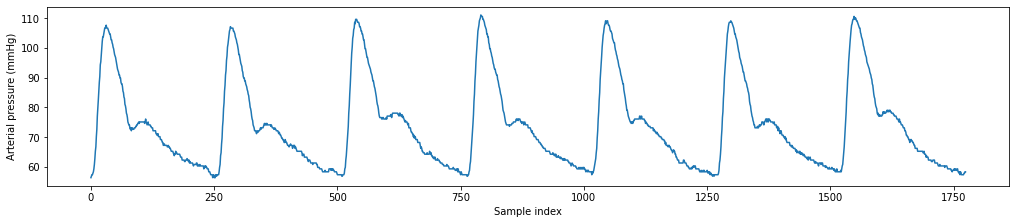

In [3]:
fig, ax = plt.subplots(figsize=(14, 3), constrained_layout=True)
ax.plot(art)
ax.set(xlabel='Sample index', ylabel='Arterial pressure (mmHg)')
plt.show()

Perform some initial smoothing so that we don't end up fitting the cubic splines to noise:

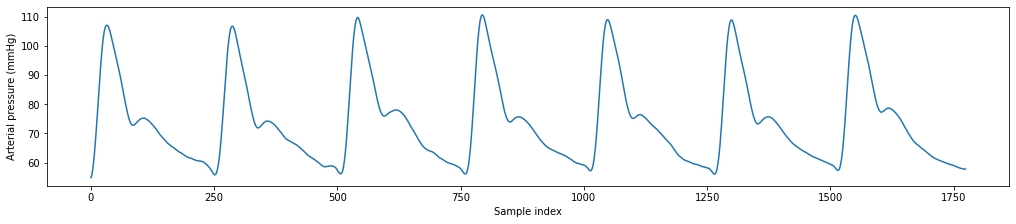

In [4]:
art_smooth = savgol_filter(art, window_length=39, polyorder=3)

fig, ax = plt.subplots(figsize=(14, 3), constrained_layout=True)
ax.plot(art_smooth)
ax.set(xlabel='Sample index', ylabel='Arterial pressure (mmHg)')
plt.show()

Isolate a nice-looking individual cardiac cycle:

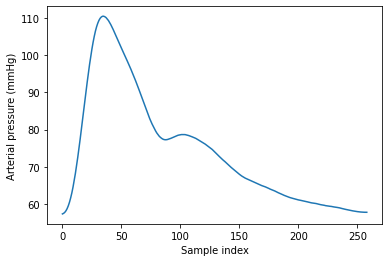

In [5]:
smooth_beat = art_smooth[1516:]

fig, ax = plt.subplots()
ax.plot(smooth_beat)
ax.set(xlabel='Sample index', ylabel='Arterial pressure (mmHg)')
plt.show()

Fit a cyclic cubic spline model, to guarantee that starting and ending pressures are the same (this will eliminate discontinuities when joining multiple copies of the beat together):

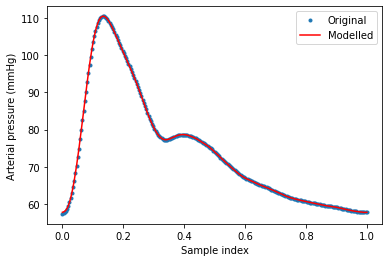

In [6]:
time = np.linspace(0, 1, smooth_beat.size)

mod = smf.quantreg('beat ~ cc(time, df=50)', dict(time=time, beat=smooth_beat))
result = mod.fit()
modelled_beat = result.predict()

fig, ax = plt.subplots()
ax.plot(time, smooth_beat, '.', label='Original')
ax.plot(time, modelled_beat, 'r', label='Modelled')
ax.set(xlabel='Sample index', ylabel='Arterial pressure (mmHg)')
ax.legend()
plt.show()

Save the modelled beat as a binary file:

In [7]:
np.save(
    file=os.path.join(
        get_root_directory(),
        'sidewinder',
        'data',
        'example_arterial_pressure_waveform'
    ),
    arr=modelled_beat
)